# Data Pre-processing & Modelling

### This notebook is organised as per the following parts:
- Part 1: Data processing for the combined apple and samsung datasets; prepare corpus for "give-away" words as present and absent for modelling
- Part 2: Create a prelim model with i) Naive Bayes classifier with the "give-away" words present in the corpus to act as a "target baseline model" to meet
- Part 3: Create an actual model with Naive Bayes classifier with the "give-away" words absent in the corpus
- Part 4: Create a prelim model with ii) Logistic Regression classifier with the "give-away" words present in the corpus to act as a "target baseline model" to meet
- Part 5: Create an actual model with Logistic Regression classifier with the "give-away" words absent in the corpus
- Part 6: From the selected model, zoom into the False Positive, False Negative, True Positive and True Negative reddit posts for further exploration



### Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import RegexpTokenizer 
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
from wordcloud import WordCloud
#for modelling
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, roc_auc_score,plot_roc_curve

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/elizahambali/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Part 1: Model with combined apple and samsung datasets

In [2]:
#read the datasets
df_apple = pd.read_csv('../datasets/df_apple.csv')
df_samsung = pd.read_csv('../datasets/df_samsung.csv')

In [3]:
# concat df_apple and df_samsung / apple_corpus and samsung_corpus
corpus_df = pd.concat([df_apple,df_samsung],ignore_index=True)
corpus_df.head(2)

,title,score,id,subreddit,url,num_comments,body,created,text,text_clean
0,"daily advice thread - march 03, 2023",16,11gxv1z,apple,https://www.reddit.com/r/apple/comments/11gxv1...,21,welcome to the daily advice thread for /r/appl...,1.677841e+09,"daily advice thread - march 03, 2023 welcome t...",daily advice thread march 03 2023 welcome to ...
1,"apple now charges more for iphone, ipad and ma...",623,11hc55r,apple,https://www.cultofmac.com/807873/apple-charges...,114,NaN,1.677871e+09,"apple now charges more for iphone, ipad and ma...",apple now charges more for iphone ipad and mac...


In [4]:
#check tail
corpus_df.tail(2)

,title,score,id,subreddit,url,num_comments,body,created,text,text_clean
2838,"getting my s23u soon, carrier plans for usa?",0,112f7bg,samsung,https://www.reddit.com/r/samsung/comments/112f...,24,i should hopefully be picking my s23u up frida...,1.676406e+09,"getting my s23u soon, carrier plans for usa? i...",getting my s23u soon carrier plans for usa i s...
2839,shipping time,1,112f68w,samsung,https://www.reddit.com/r/samsung/comments/112f...,1,ordered my s23 ultra a week ago and still no s...,1.676406e+09,shipping time ordered my s23 ultra a week ago ...,shipping time ordered my s23 ultra a week ago ...


In [5]:
# replace apple = 0 (negative) and samsung = 1 (positive )in subreddit column, renamed as label
corpus_df['subreddit'] = corpus_df['subreddit'].replace({'apple':0,'samsung':1})
corpus_df = corpus_df.rename(columns = {'subreddit':'label'})
corpus_df = corpus_df.rename(columns = {'subreddit':'label'})
#
corpus_df

,title,score,id,label,url,num_comments,body,created,text,text_clean
0,"daily advice thread - march 03, 2023",16,11gxv1z,0,https://www.reddit.com/r/apple/comments/11gxv1...,21,welcome to the daily advice thread for /r/appl...,1.677841e+09,"daily advice thread - march 03, 2023 welcome t...",daily advice thread march 03 2023 welcome to ...
1,"apple now charges more for iphone, ipad and ma...",623,11hc55r,0,https://www.cultofmac.com/807873/apple-charges...,114,NaN,1.677871e+09,"apple now charges more for iphone, ipad and ma...",apple now charges more for iphone ipad and mac...
2,sources: apple planning product briefing next ...,833,11h3oe6,0,https://www.macrumors.com/2023/03/03/iphone-14...,140,NaN,1.677858e+09,sources: apple planning product briefing next ...,sources apple planning product briefing next w...
3,apple rumored to announce 15-inch macbook air ...,183,11hffs3,0,https://www.macrumors.com/2023/03/03/apple-rum...,61,NaN,1.677879e+09,apple rumored to announce 15-inch macbook air ...,apple rumored to announce 15inch macbook air a...
4,new foxconn plant in india may be half the siz...,676,11gz8oz,0,https://9to5mac.com/2023/03/03/new-foxconn-plant/,52,NaN,1.677846e+09,new foxconn plant in india may be half the siz...,new foxconn plant in india may be half the siz...
...,...,...,...,...,...,...,...,...,...,...
2835,"unlocked s21 ultra for 399.99, should i pick i...",7,112hovs,1,https://www.reddit.com/r/samsung/comments/112h...,16,i work at a phone repair store and we just got...,1.676413e+09,"unlocked s21 ultra for 399.99, should i pick i...",unlocked s21 ultra for 39999 should i pick it ...
2836,why does 60hz feels so bad on a 120hz panel?,5,112hjh1,1,https://www.reddit.com/r/samsung/comments/112h...,6,i just tested this. if i put my s21u on limite...,1.676412e+09,why does 60hz feels so bad on a 120hz panel? i...,why does 60hz feels so bad on a 120hz panel i ...
2837,does anyone know how to fast forward netflix?,0,112h8ao,1,https://www.reddit.com/r/samsung/comments/112h...,14,i have a q80t and can only skip forward 10 sec...,1.676412e+09,does anyone know how to fast forward netflix? ...,does anyone know how to fast forward netflix i...
2838,"getting my s23u soon, carrier plans for usa?",0,112f7bg,1,https://www.reddit.com/r/samsung/comments/112f...,24,i should hopefully be picking my s23u up frida...,1.676406e+09,"getting my s23u soon, carrier plans for usa? i...",getting my s23u soon carrier plans for usa i s...


In [6]:
#save corpus_df into a csv
corpus_df.to_csv(path_or_buf='../datasets/corpus_df.csv',index=False, header = True)

### 1.1. Data processing for prelim modeling - keep giveway words i.e. apple, samsung, ultra, mac

Text(0.5, 1.0, 'Words in Apple and Samsung Subreddits (with give-away words)')

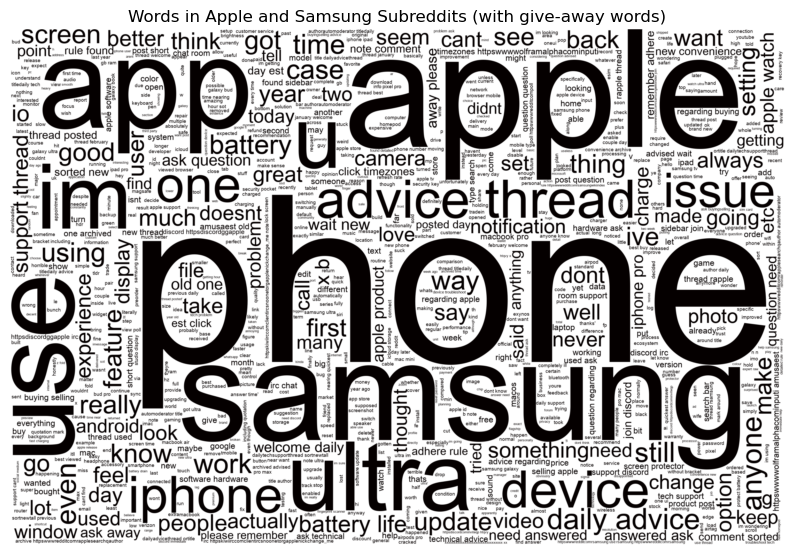

In [7]:
# pre-process corpus_df and show wordcloud
stop_words = set(stopwords.words("english"))

apple_samsung_corpus = []
for i in range(0, 2840):
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",corpus_df['text_clean'][i])
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in stop_words] 
    text = " ".join(text)
    apple_samsung_corpus.append(text)
    
# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
# set the wordcloud background color to white
# set max_words to 1000
# set width and height to higher quality, 3000 x 2000
wordcloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', background_color="white", width=3000, height=2000, max_words=1000).generate(str(apple_samsung_corpus))
# set the word color to black
wordcloud.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[10,7])
# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")
# remove plot axes
plt.axis("off")
plt.title('Words in Apple and Samsung Subreddits (with give-away words)')

In [8]:
df_apple_samsung_corpus=pd.DataFrame(apple_samsung_corpus)
df_apple_samsung_corpus

,0
0,daily advice thread march welcome daily advice...
1,apple charge iphone ipad macbook battery repla...
2,source apple planning product briefing next we...
3,apple rumored announce inch macbook air march ...
4,new foxconn plant india may half size china ip...
...,...
2835,unlocked ultra pick work phone repair store go...
2836,hz feel bad hz panel tested put u limited fram...
2837,anyone know fast forward netflix q skip forwar...
2838,getting u soon carrier plan usa hopefully pick...


Text(0, 0.5, 'Words')

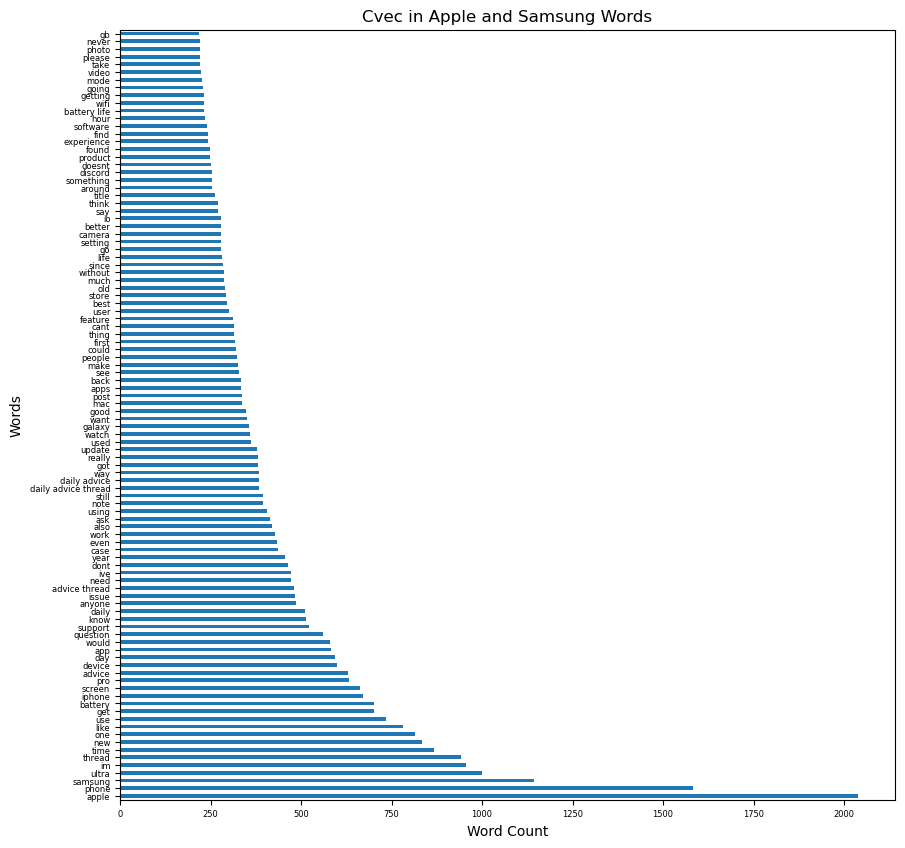

In [9]:
# tokenized the words using count vectorizer
cvec=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
words=cvec.fit_transform(apple_samsung_corpus)

# convert to dataframe 
top_words = pd.DataFrame(words.todense(),columns=cvec.get_feature_names_out())

# plot top occuring words
top_words.sum().sort_values(ascending=False).head(100).plot(kind='barh',fontsize=6,figsize=(10,10));
plt.title('Cvec in Apple and Samsung Words')
plt.xlabel('Word Count')
plt.ylabel('Words')

Text(0, 0.5, 'Words')

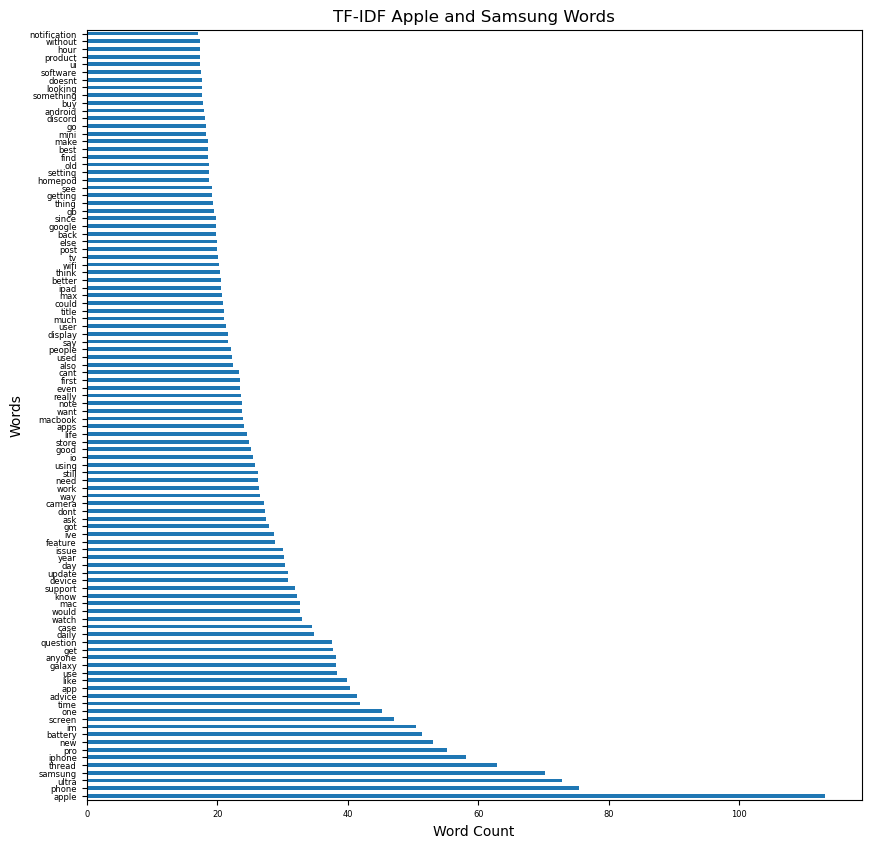

In [10]:
#tf-idf
# Instantiate and fit the transformer.
tvec = TfidfVectorizer()

# convert training data to dataframe
corpus_tfidf = pd.DataFrame(tvec.fit_transform(apple_samsung_corpus).todense(), 
                          columns=tvec.get_feature_names_out())

# plot top occuring words
corpus_tfidf.sum().sort_values(ascending=False).head(100).plot(kind='barh',fontsize=6,figsize=(10,10));
plt.title('TF-IDF Apple and Samsung Words')
plt.xlabel('Word Count')
plt.ylabel('Words')

### 1.2 Data processing for actual modeling - remove giveway words i.e. apple, samsung, iphone, ultra

Text(0.5, 1.0, 'Words in Apple and Samsung Subreddits (clean)')

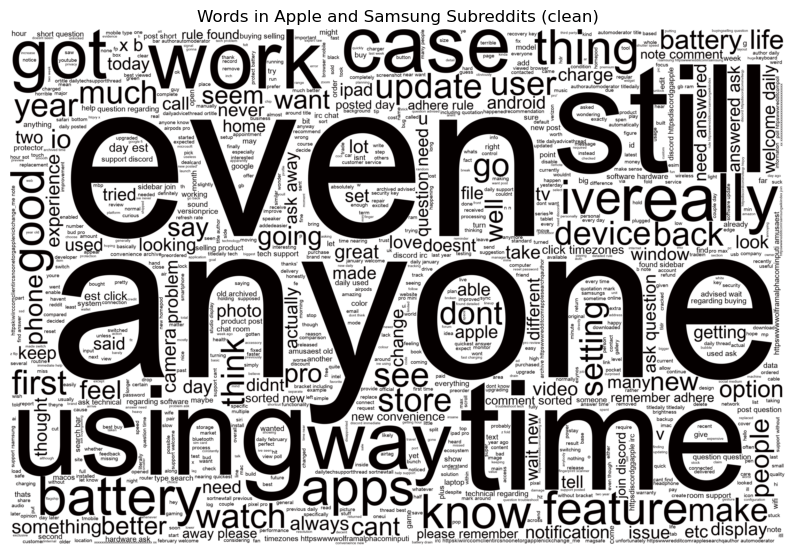

In [11]:
# pre-process corpus_df and show wordcloud
stop_words = set(stopwords.words("english"))
##Creating a list of giveaway stopwords
new_words = ['apple','samsung','iphone','iphones','icloud','imessage','ultra','macbook','mac','airpod','thread','advice','daily advice thread','daily advice',
             'advice thread','phone','galaxy','app','get','device','screen','promax','rapple','airdrop','use','im','oneU','issue','one','u']
stop_words = stop_words.union(new_words)


clean_apple_samsung_corpus = []
for i in range(0, 2840):
    
    #remove tags
    text=re.sub("&lt;/?.*?&gt;"," &lt;&gt; ",corpus_df['text_clean'][i])
    
    # remove special characters and digits
    text=re.sub("(\\d|\\W)+"," ",text)
    
    ##Convert to list from string
    text = text.split()
    
    #Lemmatisation
    lem = WordNetLemmatizer()
    text = [lem.lemmatize(word) for word in text if not word in stop_words] 
    text = " ".join(text)
    clean_apple_samsung_corpus.append(text)
    
# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
# set the wordcloud background color to white
# set max_words to 1000
# set width and height to higher quality, 3000 x 2000
wordcloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', background_color="white", width=3000, height=2000, max_words=1000).generate(str(clean_apple_samsung_corpus))
# set the word color to black
wordcloud.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[10,7])
# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")
# remove plot axes
plt.axis("off")
plt.axis('off')
plt.title('Words in Apple and Samsung Subreddits (clean)')

In [12]:
df_clean_apple_samsung_corpus=pd.DataFrame(clean_apple_samsung_corpus)
df_clean_apple_samsung_corpus

,0
0,daily march welcome daily used ask technical r...
1,charge ipad battery replacement
2,source planning product briefing next week rum...
3,rumored announce inch air march april
4,new foxconn plant india may half size china city
...,...
2835,unlocked pick work repair store got pro max re...
2836,hz feel bad hz panel tested put limited frame ...
2837,anyone know fast forward netflix q skip forwar...
2838,getting soon carrier plan usa hopefully pickin...


/Users/elizahambali/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/feature_extraction/text.py:396: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['daily', 'oneu'] not in stop_words.
  warnings.warn(


Text(0, 0.5, 'Words')

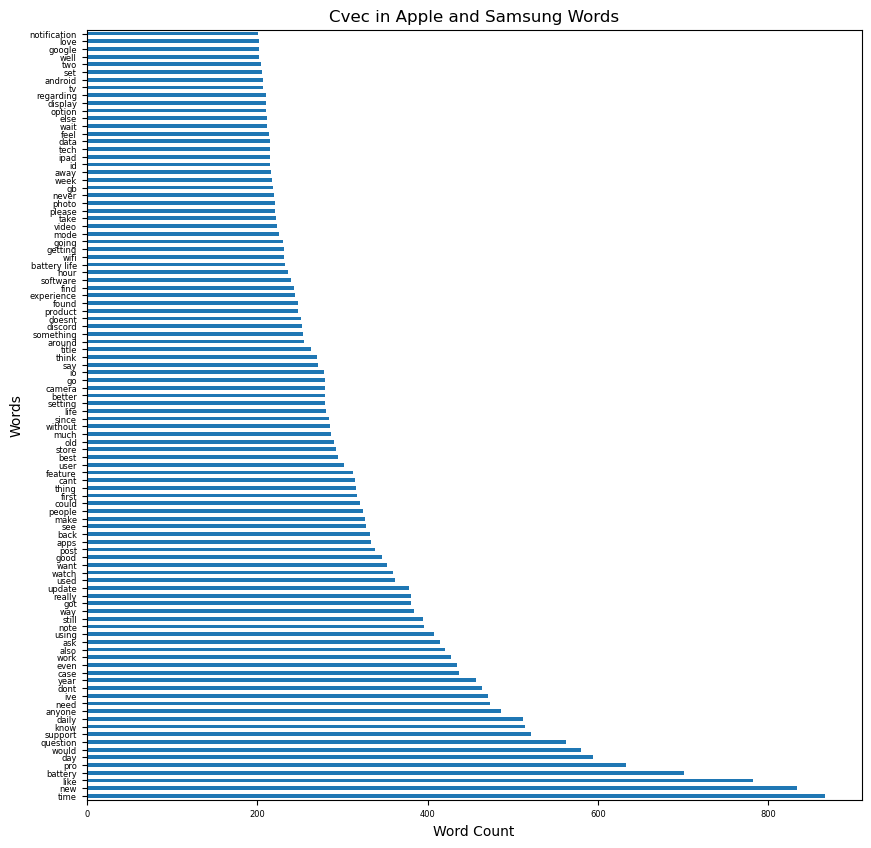

In [13]:
# tokenized the words
cvec=CountVectorizer(max_df=0.8,stop_words=stop_words, max_features=10000, ngram_range=(1,3))
words=cvec.fit_transform(clean_apple_samsung_corpus)

# convert to dataframe 
top_words = pd.DataFrame(words.todense(),columns=cvec.get_feature_names_out())

# plot top occuring words
top_words.sum().sort_values(ascending=False).head(100).plot(kind='barh',fontsize=6,figsize=(10,10));
plt.title('Cvec in Apple and Samsung Words')
plt.xlabel('Word Count')
plt.ylabel('Words')

Text(0, 0.5, 'Words')

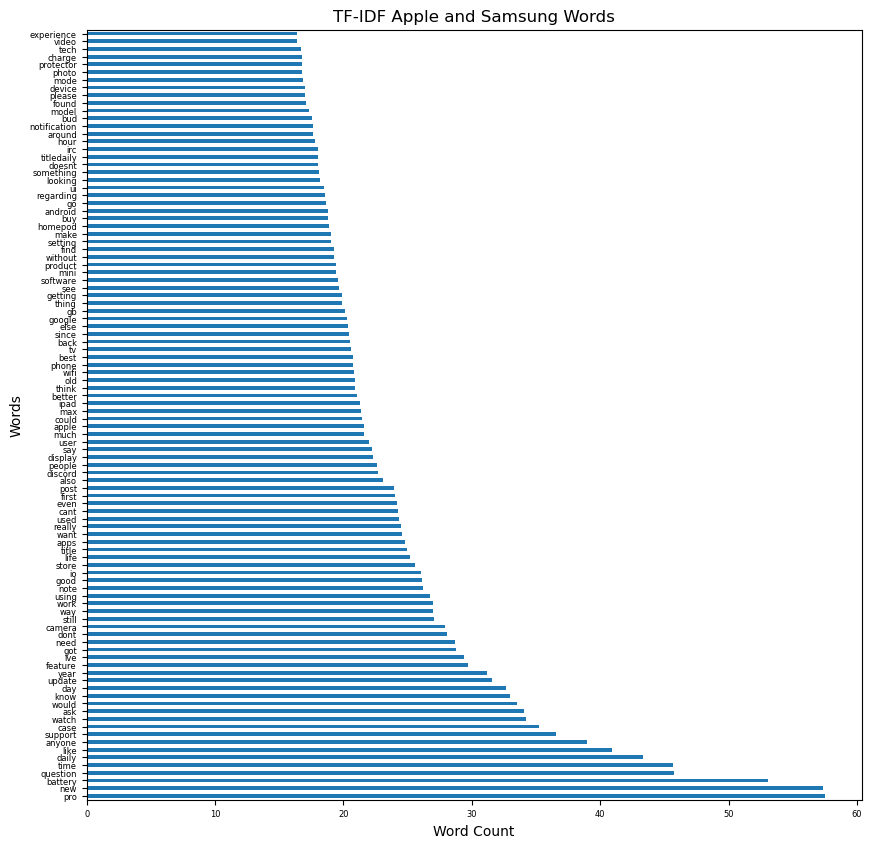

In [14]:
#tf-idf
# Instantiate and fit the transformer.
tvec = TfidfVectorizer()

# convert training data to dataframe
corpus_tfidf = pd.DataFrame(tvec.fit_transform(clean_apple_samsung_corpus).todense(), 
                          columns=tvec.get_feature_names_out())

# plot top occuring words
corpus_tfidf.sum().sort_values(ascending=False).head(100).plot(kind='barh',fontsize=6,figsize=(10,10));
plt.title('TF-IDF Apple and Samsung Words')
plt.xlabel('Word Count')
plt.ylabel('Words')

## Part 2. Prelim Model with Naive Bayes classifier 
### For part 2 and 3, we'll use the Naive Bayes a generative classifier; a machine learning model segregating different objects on the basis of certain features of variables; it uses the Bayes rule together with a strong assumption that the attributes are conditionally independent, given the class.

### 2.1 Prelim Model w Cvec and Naive Bayes w apple and samsung give-away words present in corpus. 

In [15]:
X=apple_samsung_corpus
y=corpus_df['label']

In [16]:
y.shape

(2840,)

In [17]:
# 0 = apple , 1 = samsung
y.value_counts(normalize=True)

1    0.505634
0    0.494366
Name: label, dtype: float64

In [18]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.30,
                                                    stratify=y,
                                                    random_state=42)

In [19]:
# Set up a pipeline with count vectorizer and multinomial naive bayes

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [20]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [21]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5) 

In [22]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [23]:
y_train.shape

(1988,)

In [24]:
# What's the best score?
print(gs.best_score_)

0.9195093857195296


In [25]:
# Score model on training set.
gs.score(X_train, y_train)

0.9577464788732394

In [26]:
# Score model on testing set.
gs.score(X_test, y_test)

0.9389671361502347

In [27]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()


# Calculate the recall

recall = tp / (tp + fn)

print('Recall:', recall)

# Calculate the precision

preci = tp / (tp + fp)

print('Precision:', preci)

# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)


Recall: 0.988399071925754
Precision: 0.9006342494714588
Specificity: 0.8883610451306413


/Users/elizahambali/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Prelim Model: Confusion Matrix with Naive Bayes (cvec)')

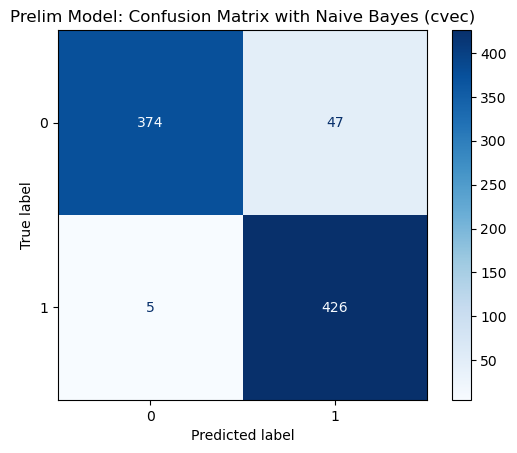

In [28]:
# View confusion matrix

plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
plt.title('Prelim Model: Confusion Matrix with Naive Bayes (cvec)')

In [29]:
preds_proba=gs.predict_proba(X_test)[:,1]
preds_proba

array([3.22193442e-003, 3.44969568e-008, 3.44559090e-007, 8.52409176e-013,
       1.91326533e-003, 1.86333016e-001, 1.26207365e-004, 5.54287447e-003,
       9.99416900e-001, 1.00000000e+000, 1.14671256e-003, 1.00000000e+000,
       9.99999929e-001, 1.00000000e+000, 1.00000000e+000, 1.00000000e+000,
       9.99999998e-001, 9.99999998e-001, 1.08449386e-004, 1.00000000e+000,
       2.09529162e-001, 1.17590048e-004, 6.69299493e-002, 9.99999757e-001,
       9.99999594e-001, 1.00000000e+000, 1.74349172e-003, 1.00000000e+000,
       1.00000000e+000, 2.40809142e-005, 1.00000000e+000, 1.48287994e-257,
       1.48287994e-257, 9.99999458e-001, 1.00000000e+000, 1.48287994e-257,
       3.17481745e-005, 1.24025010e-257, 1.21052950e-028, 5.87089735e-002,
       3.10324341e-005, 4.02112200e-004, 1.20845574e-011, 9.99999534e-001,
       5.91738850e-007, 1.42610288e-007, 1.00000000e+000, 1.00000000e+000,
       8.75186105e-001, 4.81894295e-004, 2.16493350e-005, 9.99999943e-001,
       9.99997972e-001, 2

In [30]:
nb_roc_auc_score = roc_auc_score (y_test,preds_proba)
nb_roc_auc_score

0.9837862563446882

### 2.2 Prelim Model w TFIDF and Naive Bayes w apple and samsung give-away words present in corpus. 

In [31]:
# Instantiate and fit the transformer.
tvec = TfidfVectorizer()

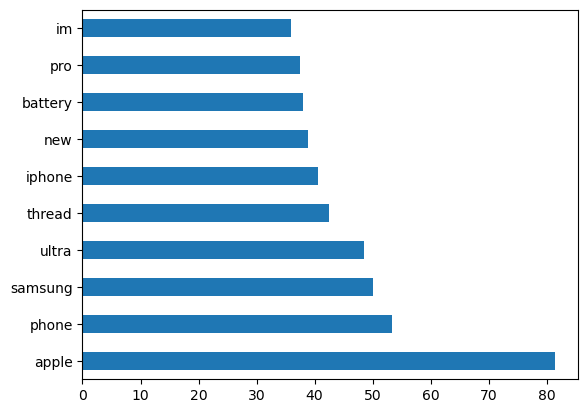

In [32]:
# convert training data to dataframe
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names_out())

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

In [33]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [34]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [35]:
# Instantiate GridSearchCV.

gs_tvec = GridSearchCV(pipe_tvec, 
                        param_grid = pipe_tvec_params, 
                        cv=5) 

In [36]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [37]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.9723340040241448

In [38]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

0.9507042253521126

In [39]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()


# Calculate the recall

recall = tp / (tp + fn)

print('Recall:', recall)

# Calculate the precision

preci = tp / (tp + fp)

print('Precision:', preci)

# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)


Recall: 0.9860788863109049
Precision: 0.9219088937093276
Specificity: 0.9144893111638955


/Users/elizahambali/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Prelim Model: Confusion Matrix with Naive Bayes (tf-idf)')

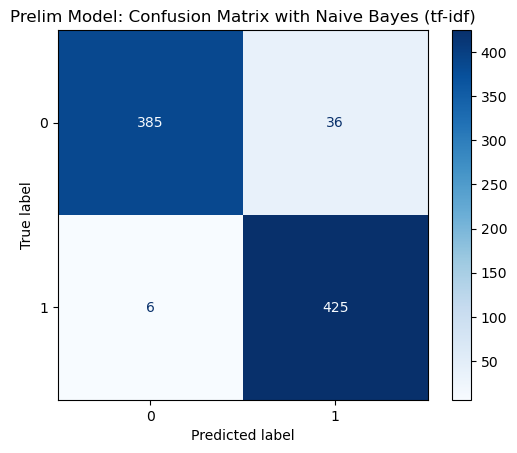

In [40]:
# visualize this

plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d');
plt.title('Prelim Model: Confusion Matrix with Naive Bayes (tf-idf)')

In [41]:
preds_tvec_proba=gs_tvec.predict_proba(X_test)[:,1]
preds_tvec_proba

array([1.57525629e-01, 1.69367742e-02, 2.73918992e-02, 6.96767746e-02,
       8.84367315e-02, 2.61574426e-01, 5.62380131e-02, 2.16229722e-01,
       8.16696079e-01, 8.98162040e-01, 1.07681439e-01, 9.83141242e-01,
       8.93317950e-01, 7.05334170e-01, 9.31631508e-01, 9.18584393e-01,
       9.76792945e-01, 5.94512785e-01, 4.16045448e-02, 9.27122928e-01,
       3.06022172e-01, 7.62936494e-02, 1.97910866e-01, 8.75490015e-01,
       8.37112583e-01, 9.14001858e-01, 1.65996399e-01, 7.22414914e-01,
       9.76125173e-01, 5.93031551e-02, 9.35454941e-01, 7.50601144e-07,
       7.50601144e-07, 7.11505356e-01, 7.05334170e-01, 7.50601144e-07,
       1.27471285e-01, 7.60147973e-07, 2.02537543e-01, 1.91118761e-01,
       6.44133541e-02, 1.31201357e-01, 1.04148720e-01, 8.61383945e-01,
       4.98163566e-01, 1.95356878e-01, 9.31208430e-01, 9.77332130e-01,
       4.17952583e-01, 8.76963727e-02, 8.89555625e-02, 7.00100371e-01,
       8.41545595e-01, 3.51992142e-02, 9.66777063e-01, 8.68118471e-01,
      

In [42]:
nb_roc_auc_score = roc_auc_score (y_test,preds_tvec_proba)
nb_roc_auc_score

0.9909507249891154

## Part 3. Actual Model with Naive Bayes

### 3.1 Model w Cvec and Naive Bayes w apple and samsung give-away words absent in corpus.

In [43]:
X=clean_apple_samsung_corpus
y=corpus_df['label']

In [44]:
# 0 = apple , 1 = samsung
y.value_counts(normalize=True)

1    0.505634
0    0.494366
Name: label, dtype: float64

In [45]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.30,
                                                    stratify=y,
                                                    random_state=42,
                                                   shuffle=True)

In [46]:
pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

In [47]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'cvec__min_df': [2, 3],
    'cvec__max_df': [.9, .95],
    'cvec__ngram_range': [(1,1), (1,2)]
}

In [48]:
# Instantiate GridSearchCV.

gs = GridSearchCV(pipe, 
                  param_grid=pipe_params, 
                  cv=5) 

In [49]:
# Fit GridSearch to training data.
gs.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'cvec__max_df': [0.9, 0.95],
                         'cvec__max_features': [2000, 3000, 4000, 5000],
                         'cvec__min_df': [2, 3],
                         'cvec__ngram_range': [(1, 1), (1, 2)]})

In [50]:
# What's the best score?
print(gs.best_score_)

0.8510904649190536


In [51]:
# Score model on training set.
gs.score(X_train, y_train)

0.9336016096579477

In [52]:
# Score model on testing set.
gs.score(X_test, y_test)

0.8708920187793427

In [53]:
# Get predictions
preds = gs.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()


# Calculate the recall

recall = tp / (tp + fn)

print('Recall:', recall)

# Calculate the precision

preci = tp / (tp + fp)

print('Precision:', preci)

# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)


Recall: 0.9327146171693735
Precision: 0.8322981366459627
Specificity: 0.8076009501187649


/Users/elizahambali/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, ' Actual Model: Confusion Matrix with Naive Bayes (cvec)')

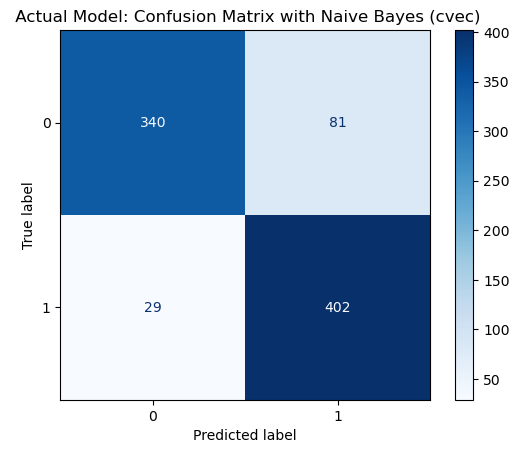

In [54]:
# View confusion matrix

plot_confusion_matrix(gs, X_test, y_test, cmap='Blues', values_format='d');
plt.title(' Actual Model: Confusion Matrix with Naive Bayes (cvec)')

In [55]:
preds_proba=gs.predict_proba(X_test)[:,1]
preds_proba

array([2.20393900e-02, 7.31771226e-04, 9.30498335e-05, 4.71404088e-11,
       6.28130745e-03, 1.48279426e-01, 1.23074086e-01, 9.00346716e-03,
       9.60375179e-01, 9.95090451e-01, 2.52637015e-02, 9.99999571e-01,
       9.99764377e-01, 1.39737811e-07, 1.00000000e+00, 9.99999565e-01,
       9.99782428e-01, 8.58129478e-01, 1.37841082e-03, 1.00000000e+00,
       4.40294747e-01, 1.55812066e-02, 5.63806620e-02, 9.99999041e-01,
       9.99852375e-01, 9.99800737e-01, 1.14993019e-02, 9.65572058e-01,
       1.00000000e+00, 7.20540622e-01, 9.99831921e-01, 7.27945003e-78,
       7.27945003e-78, 9.99999917e-01, 1.39737811e-07, 7.27945003e-78,
       5.85258425e-01, 1.38058535e-78, 9.55205785e-20, 6.28173326e-02,
       8.74060168e-03, 3.24724357e-03, 1.82811195e-07, 6.34434852e-01,
       4.75982513e-11, 6.86402813e-06, 9.98710025e-01, 9.99999999e-01,
       9.18538813e-01, 2.79211883e-03, 2.06158705e-02, 9.78216085e-01,
       9.99925289e-01, 1.34678008e-02, 9.99996794e-01, 9.99525586e-01,
      

In [56]:
pred_df = pd.DataFrame({'true_values': y_test,
                       'pred_pobs': preds_tvec_proba})
pred_df.head()

,true_values,pred_pobs
1278,0,0.157526
592,0,0.016937
217,0,0.027392
515,0,0.069677
1321,0,0.088437


/var/folders/fp/6qfmbf013yzgt56bn7s48xbm0000gn/T/ipykernel_58541/1534106332.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


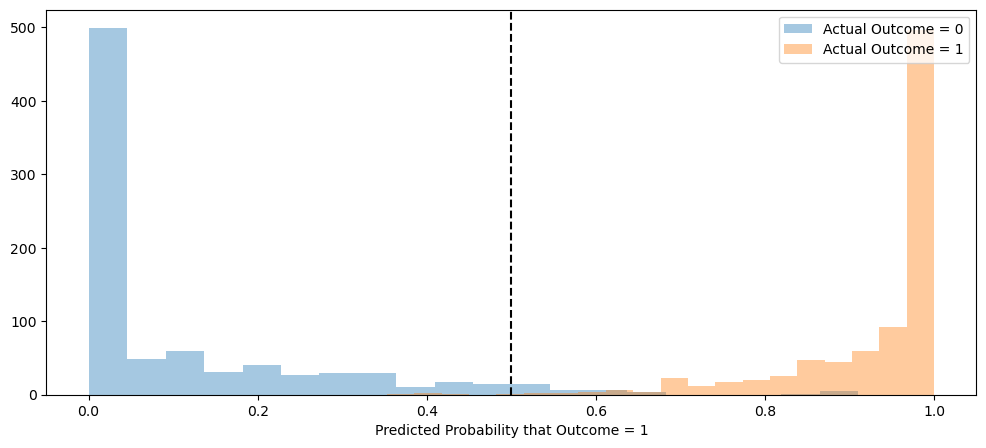

In [57]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

# Add cutoff line
plt.axvline(0.5, color = 'black', linestyle = '--')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

In [58]:
nb_roc_auc_score = roc_auc_score (y_test,preds_proba)
nb_roc_auc_score

0.9380383684851556

/Users/elizahambali/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


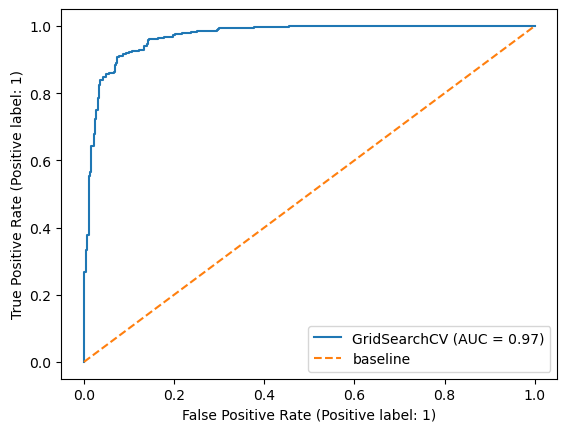

In [59]:
plot_roc_curve(gs_tvec, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

### 3.2 Model w TFIDF and Naive Bayes w apple and samsung give-away words absent in corpus.

In [60]:
# Instantiate and fit the transformer.
tvec = TfidfVectorizer()

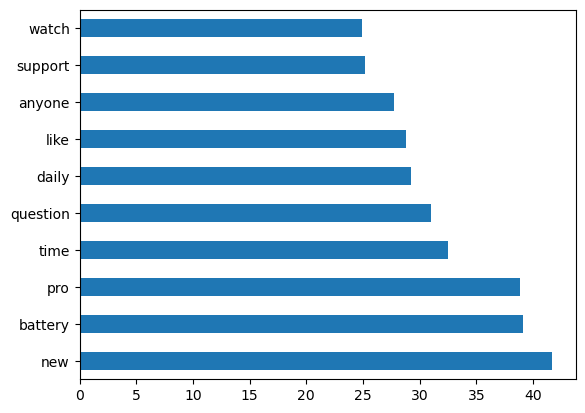

In [61]:
# convert training data to dataframe
X_train_df = pd.DataFrame(tvec.fit_transform(X_train).todense(), 
                          columns=tvec.get_feature_names_out())

# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

In [62]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('nb', MultinomialNB())
])

In [63]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [64]:
# Instantiate GridSearchCV.

nb_gs_tvec = GridSearchCV(pipe_tvec, 
                        param_grid = pipe_tvec_params, 
                        cv=5) 

In [65]:
# Fit GridSearch to training data.
nb_gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('nb', MultinomialNB())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [66]:
# Score model on training set.
nb_gs_tvec.score(X_train, y_train)

0.9537223340040242

In [67]:
# Score model on testing set.
nb_gs_tvec.score(X_test, y_test)

0.903755868544601

In [68]:
# Get predictions
nb_preds_tvec = nb_gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, nb_preds_tvec).ravel()

# Calculate the sensitivity

recall = tp / (tp + fn)

print('Recall:', recall)

# Calculate the precision

preci = tp / (tp + fp)

print('Precision:', preci)

# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)

Recall: 0.962877030162413
Precision: 0.8627858627858628
Specificity: 0.8432304038004751


/Users/elizahambali/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Actual Model: Confusion Matrix with Naive Bayes (tf-idf)')

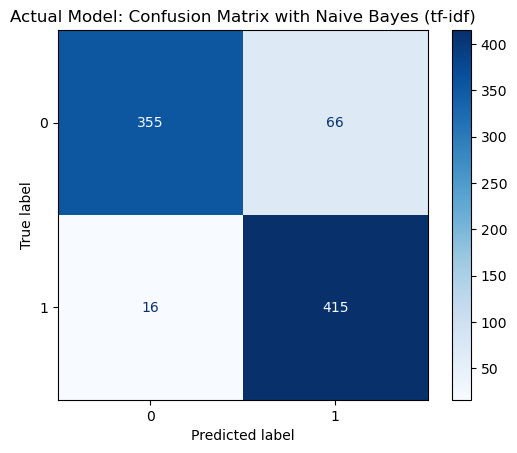

In [69]:
plot_confusion_matrix(nb_gs_tvec, X_test, y_test, cmap='Blues', values_format='d');
plt.title('Actual Model: Confusion Matrix with Naive Bayes (tf-idf)')

In [70]:
preds_tvec_proba=nb_gs_tvec.predict_proba(X_test)[:,1]
preds_tvec_proba

array([2.24562151e-01, 4.57989620e-02, 4.30836513e-02, 8.60919899e-02,
       1.47285000e-01, 2.72033534e-01, 3.00238516e-01, 2.25563505e-01,
       7.28802189e-01, 8.42659828e-01, 1.75630153e-01, 8.98836321e-01,
       7.69544316e-01, 7.37876348e-01, 9.36080739e-01, 8.56685172e-01,
       9.68899983e-01, 6.23145882e-01, 6.22479266e-02, 8.93007892e-01,
       2.64476045e-01, 2.48230418e-01, 2.02001925e-01, 8.76970020e-01,
       8.04476272e-01, 8.15225936e-01, 2.43443245e-01, 6.68007215e-01,
       9.30093780e-01, 3.85725735e-01, 7.62032847e-01, 1.21695114e-07,
       1.21695114e-07, 8.61955838e-01, 7.37876348e-01, 1.21695114e-07,
       4.69453254e-01, 1.25732802e-07, 2.88719343e-01, 1.90667559e-01,
       1.06586598e-01, 1.38129405e-01, 1.14994154e-01, 7.65661082e-01,
       5.54880538e-01, 3.46178697e-01, 8.15047023e-01, 9.52479753e-01,
       5.20433585e-01, 1.28409420e-01, 1.46092365e-01, 6.40756356e-01,
       8.53576629e-01, 7.37206829e-02, 9.33571506e-01, 8.20564133e-01,
      

In [71]:
pred_df = pd.DataFrame({'true_values': y_test,
                       'pred_pobs': preds_tvec_proba})
pred_df.head()

,true_values,pred_pobs
1278,0,0.224562
592,0,0.045799
217,0,0.043084
515,0,0.086092
1321,0,0.147285


/var/folders/fp/6qfmbf013yzgt56bn7s48xbm0000gn/T/ipykernel_58541/1534106332.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


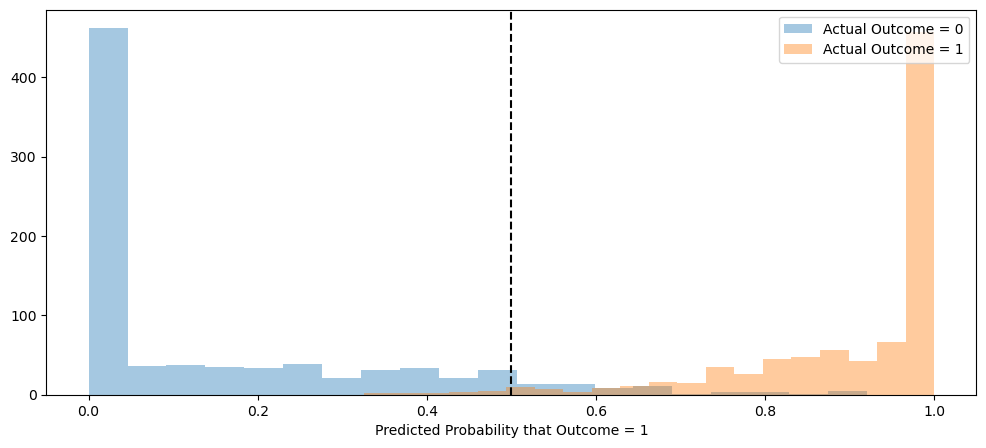

In [72]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

# Add cutoff line
plt.axvline(0.5, color = 'black', linestyle = '--')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

In [73]:
nb_roc_auc_score = roc_auc_score (y_test,preds_tvec_proba)
nb_roc_auc_score

0.9718215937084942

/Users/elizahambali/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


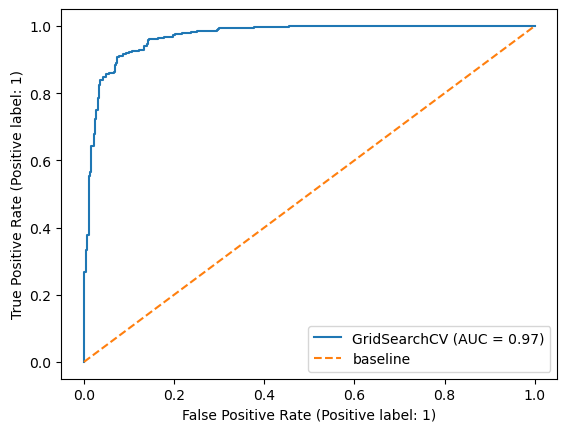

In [74]:
plot_roc_curve(gs_tvec, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

#### Naive Bayes model with TFIDF have a better score. 60 posts are predicted wrongly as samsung; should be apple posts. 15 posts were predicted wrongly as apple; should be samsung posts. 361 posts were predicted corectly as apple (True Negative) and 416 posts were predicted correctly as samsung (True Positive). As such in part 4 TFIDF will be used instead of count vectorizer for the logistics regression model.

## Part 4:  Prelim Model with Logistic Regression with give-away words present
### For part 4 and part 5 we'll use Logistic Regression; a discriminative model classifier for predicting the categorical dependent variable using a given set of independent variables.

In [75]:
X=apple_samsung_corpus
y=corpus_df['label']

In [76]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.30,
                                                    stratify=y,
                                                    random_state=42,
                                                   shuffle=True)

In [77]:
# Set up a pipeline with tf-idf vectorizer and logistic regression

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

In [78]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [79]:
# Instantiate GridSearchCV.

gs_tvec = GridSearchCV(pipe_tvec, 
                        param_grid = pipe_tvec_params, 
                        cv=5) 

In [80]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [81]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.988430583501006

In [82]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

0.9706572769953051

In [83]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()


# Calculate the recall

recall = tp / (tp + fn)

print('Recall:', recall)

# Calculate the precision

preci = tp / (tp + fp)

print('Precision:', preci)

# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)


Recall: 0.9860788863109049
Precision: 0.9572072072072072
Specificity: 0.9548693586698337


/Users/elizahambali/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Prelim Model: Confusion Matrix with Logistic Regression')

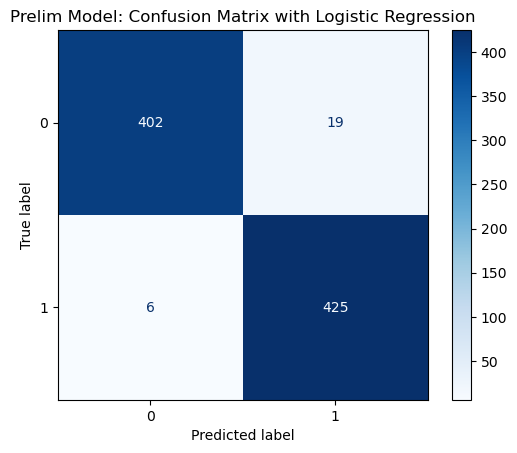

In [84]:
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d');
plt.title('Prelim Model: Confusion Matrix with Logistic Regression')

In [85]:
preds_tvec_proba=gs_tvec.predict_proba(X_test)[:,1]
preds_tvec_proba

array([0.15522732, 0.11420257, 0.06453294, 0.21756161, 0.03803122,
       0.30100351, 0.01783179, 0.2648407 , 0.75948689, 0.8410705 ,
       0.10657304, 0.97869797, 0.88403929, 0.82075637, 0.83041097,
       0.88357767, 0.89546477, 0.66985698, 0.08345594, 0.72408873,
       0.2061474 , 0.12300331, 0.22033096, 0.75801509, 0.7418526 ,
       0.94876491, 0.13435851, 0.65497175, 0.9026223 , 0.0963961 ,
       0.9012581 , 0.05886343, 0.05886343, 0.52274197, 0.82075637,
       0.05886343, 0.0945745 , 0.05840934, 0.07841284, 0.10916853,
       0.06744255, 0.32385419, 0.1627463 , 0.68426269, 0.33715401,
       0.23374595, 0.91363563, 0.94879215, 0.22842509, 0.12834535,
       0.10518393, 0.75130319, 0.66453652, 0.04096183, 0.92962001,
       0.79757364, 0.35111141, 0.95082841, 0.37629916, 0.09103426,
       0.20071444, 0.97670644, 0.17327539, 0.38062171, 0.32573824,
       0.15911412, 0.93438609, 0.91470979, 0.16421818, 0.30047908,
       0.14140304, 0.14864495, 0.35825131, 0.11963981, 0.97287

In [86]:
logreg_roc_auc_score = roc_auc_score (y_test,preds_tvec_proba)
logreg_roc_auc_score

0.9950620277650716

## Part 5. Actual Model with Logistics Regression w give-away words absent

In [87]:
X=clean_apple_samsung_corpus
y=corpus_df['label']

In [88]:
# Split the data into the training and testing sets.
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    test_size=0.30,
                                                    stratify=y,
                                                    random_state=42,
                                                   shuffle=True)

In [89]:
# Set up a pipeline with tf-idf vectorizer and multinomial naive bayes

pipe_tvec = Pipeline([
    ('tvec', TfidfVectorizer()),
    ('logreg', LogisticRegression())
])

In [90]:
# Search over the following values of hyperparameters:
# Maximum number of features fit: 2000, 3000, 4000, 5000
# No stop words and english stop words
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_tvec_params = {
    'tvec__max_features': [2_000, 3_000, 4_000, 5_000],
    'tvec__stop_words': [None, 'english'],
    'tvec__ngram_range': [(1,1), (1,2)]
}

In [91]:
# Instantiate GridSearchCV.

gs_tvec = GridSearchCV(pipe_tvec, 
                        param_grid = pipe_tvec_params,
                        cv=5) 

In [92]:
# Fit GridSearch to training data.
gs_tvec.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tvec', TfidfVectorizer()),
                                       ('logreg', LogisticRegression())]),
             param_grid={'tvec__max_features': [2000, 3000, 4000, 5000],
                         'tvec__ngram_range': [(1, 1), (1, 2)],
                         'tvec__stop_words': [None, 'english']})

In [93]:
# Score model on training set.
gs_tvec.score(X_train, y_train)

0.9763581488933601

In [94]:
# Score model on testing set.
gs_tvec.score(X_test, y_test)

0.92018779342723

In [95]:
# Get predictions
preds_tvec = gs_tvec.predict(X_test)

# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds_tvec).ravel()

# Calculate the recall

recall = tp / (tp + fn)

print('Recall:', recall)

# Calculate the precision

preci = tp / (tp + fp)

print('Precision:', preci)

# Calculate the specificity

spec = tn / (tn + fp)

print('Specificity:', spec)


Recall: 0.9071925754060325
Precision: 0.9331742243436754
Specificity: 0.9334916864608076


/Users/elizahambali/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Actual Model: Confusion Matrix with Logistic Regression')

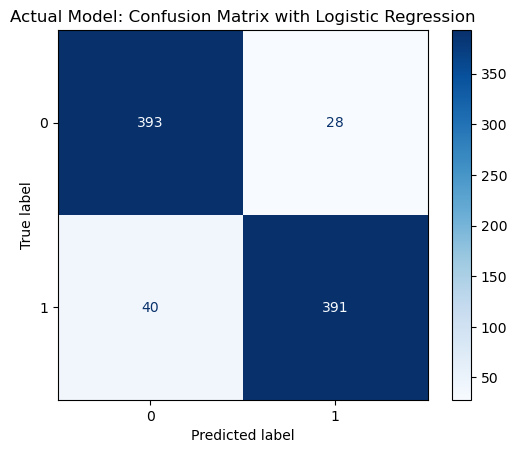

In [96]:
plot_confusion_matrix(gs_tvec, X_test, y_test, cmap='Blues', values_format='d');
plt.title('Actual Model: Confusion Matrix with Logistic Regression')

In [97]:
preds_tvec_proba=gs_tvec.predict_proba(X_test)[:,1]
preds_tvec_proba

array([0.27398281, 0.14111443, 0.12567334, 0.19149996, 0.10513792,
       0.2919518 , 0.30600285, 0.23912857, 0.58335082, 0.66631099,
       0.27757249, 0.78379843, 0.66900926, 0.80467569, 0.85275504,
       0.75214188, 0.85911585, 0.40997242, 0.17194904, 0.69934225,
       0.30286079, 0.17317082, 0.19898955, 0.81469499, 0.69797139,
       0.70350613, 0.26728025, 0.5922055 , 0.82286522, 0.20578721,
       0.69760583, 0.06491084, 0.06491084, 0.79425562, 0.80467569,
       0.06491084, 0.419729  , 0.06318527, 0.23209448, 0.1920867 ,
       0.18013368, 0.22443845, 0.16517595, 0.49278315, 0.44094071,
       0.3296047 , 0.72249808, 0.83246229, 0.38567668, 0.294972  ,
       0.18425205, 0.48623365, 0.6998347 , 0.15449966, 0.83086786,
       0.75686841, 0.29978806, 0.90704654, 0.39619925, 0.12371274,
       0.39480977, 0.87852267, 0.28949828, 0.42478211, 0.27903234,
       0.34475454, 0.82665942, 0.60313194, 0.18670996, 0.45801114,
       0.26293346, 0.38302573, 0.34685703, 0.34745556, 0.32720

In [98]:
pred_df = pd.DataFrame({'true_values': y_test,
                       'pred_pobs': preds_tvec_proba})
pred_df.head()

,true_values,pred_pobs
1278,0,0.273983
592,0,0.141114
217,0,0.125673
515,0,0.191500
1321,0,0.105138


/var/folders/fp/6qfmbf013yzgt56bn7s48xbm0000gn/T/ipykernel_58541/1534106332.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')


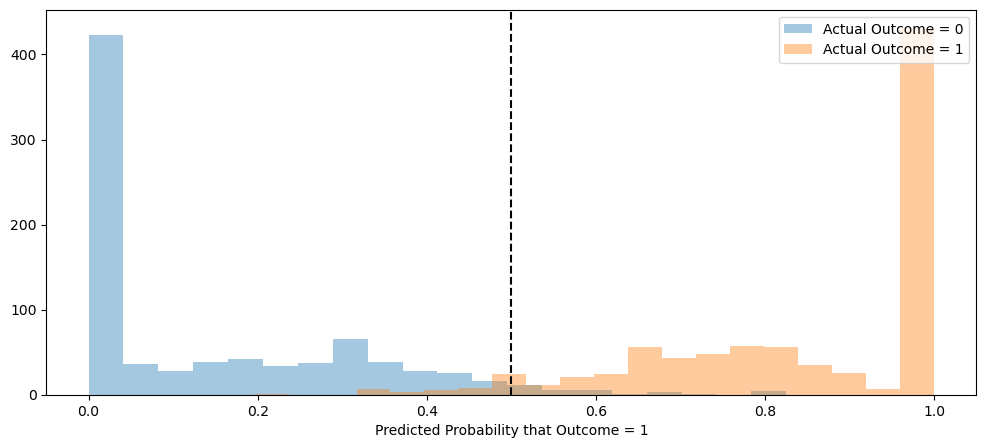

In [99]:
plt.figure(figsize = (12, 5))

# plot distributions of predicted probabilities by actual values
for group in pred_df.groupby('true_values'):
    sns.distplot(group[1], kde = False, bins = 20, label = f'Actual Outcome = {group[0]}')

# Add cutoff line
plt.axvline(0.5, color = 'black', linestyle = '--')

plt.xlabel('Predicted Probability that Outcome = 1')
plt.legend();

In [100]:
logreg_roc_auc_score = roc_auc_score (y_test,preds_tvec_proba)
logreg_roc_auc_score

0.973381243421089

/Users/elizahambali/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_roc_curve is deprecated; Function :func:`plot_roc_curve` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: :meth:`sklearn.metric.RocCurveDisplay.from_predictions` or :meth:`sklearn.metric.RocCurveDisplay.from_estimator`.
  warnings.warn(msg, category=FutureWarning)


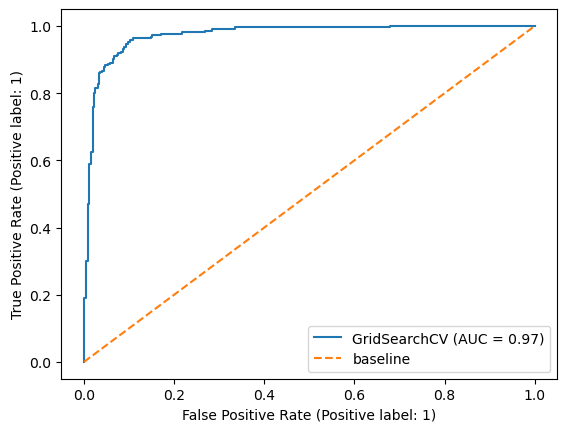

In [101]:
plot_roc_curve(gs_tvec, X_test, y_test)
plt.plot([0, 1], [0, 1],
         label='baseline', linestyle='--')
plt.legend();

## Part 6: Zoom into the false positive, false negative, true positive and true negative posts from the selected model 

/Users/elizahambali/opt/anaconda3/envs/dsi-sg/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


Text(0.5, 1.0, 'Actual Model: Confusion Matrix with Naive Bayes (tf-idf)')

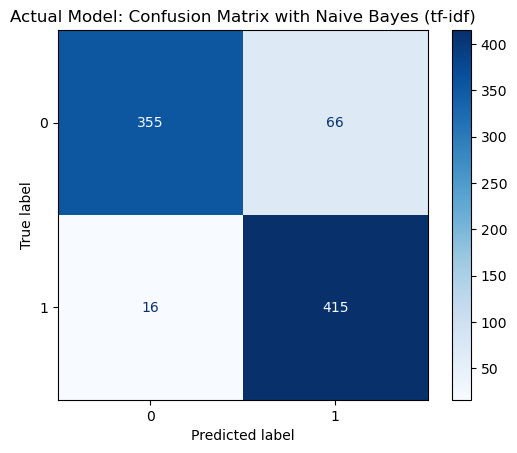

In [102]:
plot_confusion_matrix(nb_gs_tvec, X_test, y_test, cmap='Blues', values_format='d');
plt.title('Actual Model: Confusion Matrix with Naive Bayes (tf-idf)')

In [103]:
# the 16 posts that were wrongly predicted as apple. should be samsung posts. 
fn = np.where((y_test == 1) & (nb_preds_tvec == 0))[0]

# the 66 posts that were wrongly predicted as samsung. should be apple posts.
fp = np.where((y_test == 0) & (nb_preds_tvec == 1))[0]

print('False Negative Array')
print(fn)
print('\n')
print('False Positive Array')
print(fp)

False Negative Array
[171 250 330 338 353 385 414 450 466 499 530 537 549 660 721 826]


False Positive Array
[ 44  48  63  65  69  76  83 104 108 124 153 160 163 177 197 205 216 227
 248 251 260 265 270 297 302 305 319 337 348 383 388 398 405 425 430 455
 477 557 558 569 576 588 601 611 622 636 659 664 677 691 703 717 722 734
 747 750 751 764 767 768 779 785 789 814 819 838]


In [104]:
# the 16 posts that were wrongly predicted as apple. should be samsung posts. 
#pd.set_option('display.max_colwidth',None)
fn_posts=df_clean_apple_samsung_corpus.iloc[fn]
fn_posts

,0
171,paint program really old o version
250,fix new webkit zeroday exploited hack mac
330,genius design park neo
338,could introduce pricier
353,rumored strategy may work could easily backfir...
385,big limitation hdmi mac k hdr display
414,opinion techrax everythingapplepro happened pa...
450,remove double tap bookmark feature book distra...
466,daily january welcome daily used ask technical...
499,popular smartphone world


In [105]:
#save fn_posts into a csv
fn_posts.to_csv(path_or_buf='../datasets/fn_posts.csv',index=False, header = True)

Text(0.5, 1.0, 'False Negative Posts')

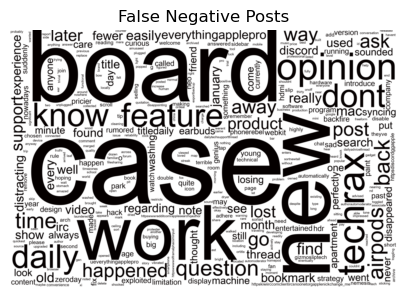

In [106]:
# Create wordcloud for fn_posts
# Read in data
fn_posts = pd.read_csv('../datasets/fn_posts.csv', encoding='utf-8')

# Concatenate text
text = ' '.join(fn_posts['0'].tolist())

# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
# set the wordcloud background color to white
# set max_words to 1000
# set width and height to higher quality, 3000 x 2000
wordcloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', background_color="white", width=3000, height=2000, max_words=1000).generate(text)
# set the word color to black
wordcloud.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[5,5])
# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")
# remove plot axes
plt.axis("off")
plt.title('False Negative Posts')

In [107]:
# the 66 posts that were wrongly predicted as samsung. should be apple posts.
#pd.set_option('display.max_colwidth',None)
fp_posts=df_clean_apple_samsung_corpus.iloc[fp]
fp_posts

,0
44,beware rogue fa apps store google playdont hacked
48,apple g modem going debut sooner expected say ...
63,made switch seeing add reddit thinking spends ...
65,since ditched dark sky go weather let face io ...
69,iosipad o background refresh hello many backgr...
...,...
785,dont create apps platform please guy need figu...
789,quick draft iosipadosmacos httpsappsapplecomus...
814,hatelove relationship homepod music enthusiast...
819,remembering steve job th birthday


In [108]:
#save fn_posts into a csv
fp_posts.to_csv(path_or_buf='../datasets/fp_posts.csv',index=False, header = True)

Text(0.5, 1.0, 'False Positive Posts')

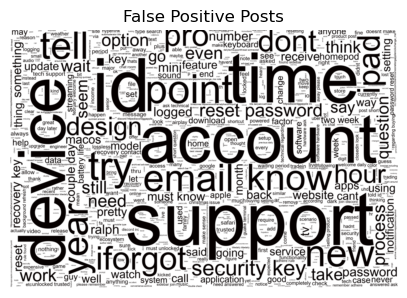

In [109]:
#Create wordcloud for fn_posts
# Read in data
fp_posts = pd.read_csv('../datasets/fp_posts.csv', encoding='utf-8')

# Concatenate text
text = ' '.join(fp_posts['0'].tolist())

# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
# set the wordcloud background color to white
# set max_words to 1000
# set width and height to higher quality, 3000 x 2000
wordcloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', background_color="white", width=3000, height=2000, max_words=1000).generate(text)
# set the word color to black
wordcloud.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[5,5])
# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")
# remove plot axes
plt.axis("off")
plt.title('False Positive Posts')

In [110]:
#true_apple_posts
true_apple = np.where((y_test == 0) & (nb_preds_tvec == 0))[0]

In [111]:
#pd.set_option('display.max_colwidth',None)
tn_true_apple_posts=df_clean_apple_samsung_corpus.iloc[true_apple]
tn_true_apple_posts

,0
0,daily march welcome daily used ask technical r...
1,charge ipad battery replacement
2,source planning product briefing next week rum...
3,rumored announce inch air march april
4,new foxconn plant india may half size china city
...,...
840,whatsapp add pictureinpicture video call io
841,daily february welcome daily used ask technica...
842,safari admission
846,bloomberg make major progress noprick blood gl...


In [112]:
#save tn_true_apple_posts into a csv
tn_true_apple_posts.to_csv(path_or_buf='../datasets/tn_posts.csv',index=False, header = True)

Text(0.5, 1.0, 'True Negative Posts (Apple Posts)')

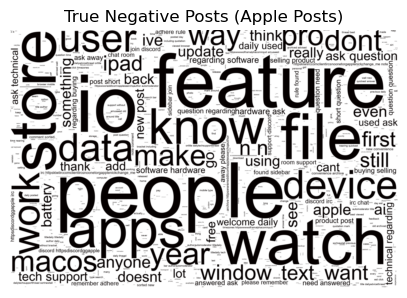

In [113]:
# Create wordcloud for tn_posts
# Read in data
tn_true_apple_posts = pd.read_csv('../datasets/tn_posts.csv', encoding='utf-8')

# Concatenate text
text = ' '.join(tn_true_apple_posts['0'].tolist())

# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
# set the wordcloud background color to white
# set max_words to 1000
# set width and height to higher quality, 3000 x 2000
wordcloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', background_color="white", width=3000, height=2000, max_words=1000).generate(text)
# set the word color to black
wordcloud.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[5,5])
# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")
# remove plot axes
plt.axis("off")
plt.title('True Negative Posts (Apple Posts)')

In [114]:
#save true_apple_posts into a csv
tn_true_apple_posts.to_csv(path_or_buf='../datasets/tn_true_apple_posts.csv',index=False, header = True)

In [115]:
#true_samsung_posts
true_samsung = np.where((y_test == 1) & (nb_preds_tvec == 1))[0]

In [116]:
#pd.set_option('display.max_colwidth',None)
tp_true_samsung_posts=df_clean_apple_samsung_corpus.iloc[true_samsung]
tp_true_samsung_posts

,0
8,diversifies production china new plant india
9,survives meter deep lake week
11,privacy label helped decide whether download w...
12,block update chatgptpowered concern grow ai po...
13,stolen delivery filed police report apple say ...
...,...
845,lineup rumored feature powerefficient oled dis...
847,doesnt airplay protocol application fast makin...
848,id like dedicate brief moment favorite th gene...
850,flat good camera huge camera bump great camera...


In [117]:
#save tp_true_samsung_posts into a csv
tp_true_samsung_posts.to_csv(path_or_buf='../datasets/tp_posts.csv',index=False, header = True)

Text(0.5, 1.0, 'True Positive Posts (Samsung Posts)')

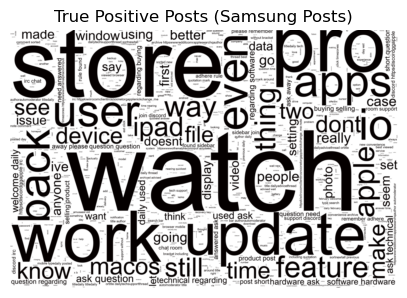

In [118]:
# Create wordcloud for tp_posts
# Read in data
tp_true_samsung_posts = pd.read_csv('../datasets/tp_posts.csv', encoding='utf-8')

# Concatenate text
text = ' '.join(tp_true_samsung_posts['0'].tolist())

# change the value to black
def black_color_func(word, font_size, position,orientation,random_state=None, **kwargs):
    return("hsl(0,100%, 1%)")
# set the wordcloud background color to white
# set max_words to 1000
# set width and height to higher quality, 3000 x 2000
wordcloud = WordCloud(font_path = '/Library/Fonts/Arial Unicode.ttf', background_color="white", width=3000, height=2000, max_words=1000).generate(text)
# set the word color to black
wordcloud.recolor(color_func = black_color_func)
# set the figsize
plt.figure(figsize=[5,5])
# plot the wordcloud
plt.imshow(wordcloud, interpolation="bilinear")
# remove plot axes
plt.axis("off")
plt.title('True Positive Posts (Samsung Posts)')

In [119]:
#save true_samsung_posts into a csv
tp_true_samsung_posts.to_csv(path_or_buf='../datasets/tp_true_samsung_posts.csv',index=False, header = True)

# Conclusion and Recommendation

Based on the different models, it concludes that the naive based tf-idf model is better at meeting the samsung marketing team's task 1 classification of classifying samsung post into to the correct bucket. The goal is to achieve a high recall where the True Positive posts (samsung posts) are maximised and the False Negative posts are minimised. This is to ensure that all the actual samsung posts are in the samsung bucket. Hence, it is recommended for the data science team to deploy this model as a start, and if required to train it further to meet their task 1 classification.